# Task 2 - Applying LDA to **Wine Quality (White)**

**Goal:** Apply LDA on a real dataset:
- Data sanity checks (missing values, target distribution)
- **LDA as classifier** (train/test + report)
- **Cross-validation** (stable estimate)
- **Baseline vs LDA→LogReg pipeline**
- **PCA(2D) vs LDA(2D)** visualization (multiclass)

**Dataset:** `winequality-white.csv`


## 0) Imports

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

## 1) Load the dataset

The path is:
- `../datasets/raw/HW1/winequality-white.csv`

The UCI wine datasets are typically **semicolon-separated**, so we use `sep=";"`.

In [56]:
df = pd.read_csv("../../../../datasets/raw/HW1/winequality-white.csv", sep=";")
print("Shape:", df.shape)
df.head()

Shape: (4898, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


## 2) Quick data checks (missing values + target distribution)

We care about:
- Are there missing values?
- Is the target (`quality`) imbalanced?


Total missing values: 0

Quality distribution (counts):


quality
3      20
4     163
5    1457
6    2198
7     880
8     175
9       5
Name: count, dtype: int64

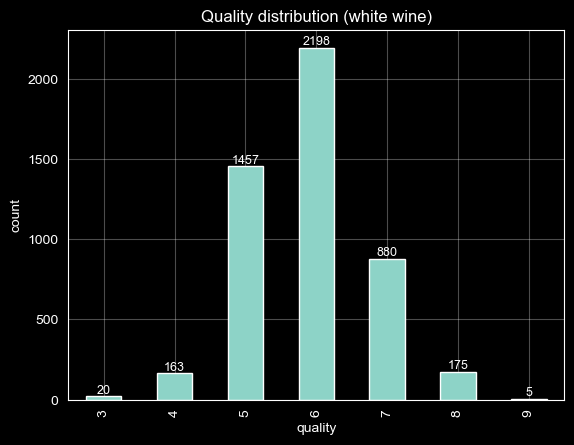

In [66]:
print("Total missing values:", df.isna().sum().sum())

print("\nQuality distribution (counts):")
counts = df["quality"].value_counts().sort_index()
display(counts)

ax = counts.plot(kind="bar")
plt.xlabel("quality")
plt.ylabel("count")
plt.title("Quality distribution (white wine)")
plt.grid(True, alpha=0.3)

# add labels on top of bars
for p in ax.patches:
    ax.annotate(
        f"{int(p.get_height())}",
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha="center",
        va="bottom",
        fontsize=9
    )

plt.show()

## 3) Create labels for the experiments (3-class target)

The original `quality` variable has multiple integer values (e.g., 3–9). <br>
For **LDA experiments**, it’s useful to group these values into a smaller number of classes so we can:

- treat the problem as a **multi-class classification** task
- make **PCA vs LDA** visual comparisons in **2D** easier to interpret

### We create a new label: `quality3`

- **1 (low)**: quality ≤ 4
- **2 (medium)**: quality 5–6
- **3 (high)**: quality ≥ 7

This produces **C = 3 classes**.

### Why this matters for LDA
LDA can only produce up to:

$$
n_{components} \le C - 1 = 2
$$

So with three classes, LDA can create **two discriminant axes (LD1 and LD2)** — perfect for a 2D plot and directly comparable to PCA(2).

Class counts (quality3):


quality3
1     183
2    3655
3    1060
Name: count, dtype: int64

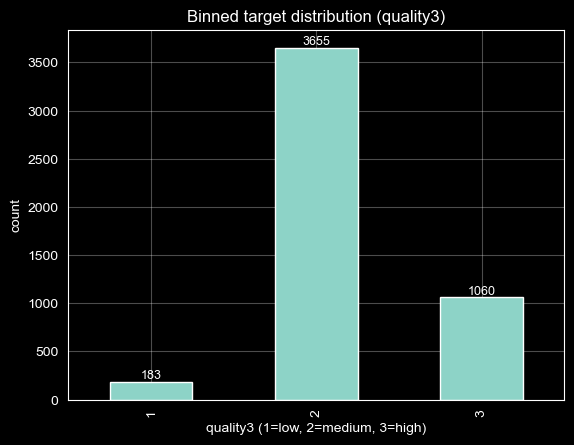

In [73]:
df["quality3"] = np.where(
    df["quality"] <= 4, 1,
    np.where(df["quality"] <= 6, 2, 3)
)

counts3 = df["quality3"].value_counts().sort_index()

print("Class counts (quality3):")
display(counts3)

ax = counts3.plot(kind="bar")
plt.xlabel("quality3 (1=low, 2=medium, 3=high)")
plt.ylabel("count")
plt.title("Binned target distribution (quality3)")
plt.grid(True, alpha=0.3)

# add labels on top of bars
for p in ax.patches:
    ax.annotate(
        f"{int(p.get_height())}",
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha="center",
        va="bottom",
        fontsize=9
    )

plt.show()

## 4) Prepare X and y

- **X**: all physicochemical features
- **y**: our binned class label `quality3`


In [74]:
X = df.drop(columns=["quality", "quality3"])
y = df["quality3"].to_numpy()

print("X shape:", X.shape)
print("y classes:", np.unique(y))

X shape: (4898, 11)
y classes: [1 2 3]


## 5) LDA as a classifier (train/test split)

This is the “direct LDA” mode from Lecture 2:
- Standardize features
- Fit LDA classifier
- Evaluate on held-out test set

Note: because classes may be imbalanced, we report:
- **accuracy**
- **macro F1** (treats classes equally)


In [75]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

pipe_lda_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("lda", LinearDiscriminantAnalysis())
])

pipe_lda_clf.fit(X_train, y_train)
y_pred = pipe_lda_clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1m = f1_score(y_test, y_pred, average="macro")

print(f"Test accuracy: {acc:.4f}")
print(f"Test macro F1: {f1m:.4f}")

print("\nClassification report (test):\n")
print(classification_report(y_test, y_pred, digits=4))

print("Confusion matrix (test):")
cm = confusion_matrix(y_test, y_pred, labels=[1,2,3])
cm_df = pd.DataFrame(cm, index=["Actual 1","Actual 2","Actual 3"], columns=["Pred 1","Pred 2","Pred 3"])
display(cm_df)

Test accuracy: 0.7612
Test macro F1: 0.4983

Classification report (test):

              precision    recall  f1-score   support

           1     0.3462    0.1636    0.2222        55
           2     0.7957    0.9161    0.8517      1097
           3     0.5801    0.3302    0.4208       318

    accuracy                         0.7612      1470
   macro avg     0.5740    0.4700    0.4983      1470
weighted avg     0.7323    0.7612    0.7349      1470

Confusion matrix (test):


,Pred 1,Pred 2,Pred 3
Actual 1,9,45,1
Actual 2,17,1005,75
Actual 3,0,213,105


## 6) Cross-validation for LDA (more reliable performance estimate)

A single train/test split can be **sensitive to randomness** (which points end up in train vs test). <br>
To obtain a more stable and trustworthy estimate of performance, we use **cross-validation**.

### Why Repeated Stratified K-Fold?
We use **Repeated Stratified K-Fold** because it provides two key benefits:

- **Stratified**: each fold preserves the original class proportions
  (important here because `quality3` is typically imbalanced)
- **Repeated**: the entire K-Fold procedure is repeated multiple times
  to reduce variance and make the mean score more reliable

### What metrics do we report?
We compute the mean and standard deviation (**mean ± std**) across all CV folds for:

- **Accuracy**: overall fraction of correct predictions
- **Macro F1**: averages F1 across classes equally (each class has the same weight)

Macro F1 is especially important when classes are imbalanced, because it prevents the majority class from dominating the evaluation.


In [79]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

scores_acc = cross_val_score(pipe_lda_clf, X, y, scoring="accuracy", cv=cv, n_jobs=-1)
scores_f1m = cross_val_score(pipe_lda_clf, X, y, scoring="f1_macro", cv=cv, n_jobs=-1)

print(f"CV Accuracy: {scores_acc.mean():.4f} ± {scores_acc.std():.4f}")
print(f"CV F1-macro: {scores_f1m.mean():.4f} ± {scores_f1m.std():.4f}")
print("First 10 acc scores:", np.round(scores_acc[:10], 3))

CV Accuracy: 0.7609 ± 0.0115
CV F1-macro: 0.5025 ± 0.0367
First 10 acc scores: [0.765 0.78  0.739 0.761 0.767 0.751 0.78  0.759 0.74  0.765]


## 7) Baseline vs LDA → Logistic Regression (Lecture 2 pipeline idea)

Now we compare two pipelines:

### Baseline
`StandardScaler → LogisticRegression`

### LDA pipeline
`StandardScaler → LDA(n_components=2) → LogisticRegression`

Because we have **3 classes**, LDA can produce up to 2 components.


In [80]:
baseline = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=5000, multi_class="auto"))
])

lda_logreg = Pipeline([
    ("scaler", StandardScaler()),
    ("lda", LinearDiscriminantAnalysis(n_components=2)),
    ("logreg", LogisticRegression(max_iter=5000, multi_class="auto"))
])

base_acc = cross_val_score(baseline, X, y, scoring="accuracy", cv=cv, n_jobs=-1)
base_f1m = cross_val_score(baseline, X, y, scoring="f1_macro", cv=cv, n_jobs=-1)

lda_acc = cross_val_score(lda_logreg, X, y, scoring="accuracy", cv=cv, n_jobs=-1)
lda_f1m = cross_val_score(lda_logreg, X, y, scoring="f1_macro", cv=cv, n_jobs=-1)

print("Baseline (Scaler+LogReg)")
print(f"  CV Accuracy: {base_acc.mean():.4f} ± {base_acc.std():.4f}")
print(f"  CV F1-macro: {base_f1m.mean():.4f} ± {base_f1m.std():.4f}")

print("\nLDA(2) + LogReg")
print(f"  CV Accuracy: {lda_acc.mean():.4f} ± {lda_acc.std():.4f}")
print(f"  CV F1-macro: {lda_f1m.mean():.4f} ± {lda_f1m.std():.4f}")

print("\nDelta (LDA - baseline)")
print(f"  ΔAccuracy: {(lda_acc.mean() - base_acc.mean()):.4f}")
print(f"  ΔF1-macro: {(lda_f1m.mean() - base_f1m.mean()):.4f}")

Baseline (Scaler+LogReg)
  CV Accuracy: 0.7638 ± 0.0120
  CV F1-macro: 0.4411 ± 0.0305

LDA(2) + LogReg
  CV Accuracy: 0.7649 ± 0.0117
  CV F1-macro: 0.4501 ± 0.0314

Delta (LDA - baseline)
  ΔAccuracy: 0.0011
  ΔF1-macro: 0.0090


## 8) PCA(2D) vs LDA(2D) visualization (the “why LDA exists” demo)

We standardize X first, then:
- PCA(2) ignores labels → preserves variance
- LDA(2) uses labels → preserves class separation

We also print:
- PCA explained variance ratio (how much variance 2 PCs capture)
- LDA explained variance ratio (how discriminative power splits across LD1/LD2)


In [81]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA 2D
pca = PCA(n_components=2)
X_pca2 = pca.fit_transform(X_scaled)

print("PCA explained variance ratio:", np.round(pca.explained_variance_ratio_, 4))
print("PCA total (2D):", np.round(pca.explained_variance_ratio_.sum(), 4))

# LDA 2D (C=3 => max 2 components)
lda2 = LinearDiscriminantAnalysis(n_components=2)
X_lda2 = lda2.fit(X_scaled, y).transform(X_scaled)

if hasattr(lda2, "explained_variance_ratio_"):
    print("\nLDA explained variance ratio:", np.round(lda2.explained_variance_ratio_, 4))
    print("LDA total (2D):", np.round(lda2.explained_variance_ratio_.sum(), 4))

PCA explained variance ratio: [0.2929 0.1432]
PCA total (2D): 0.4361

LDA explained variance ratio: [0.8132 0.1868]
LDA total (2D): 1.0


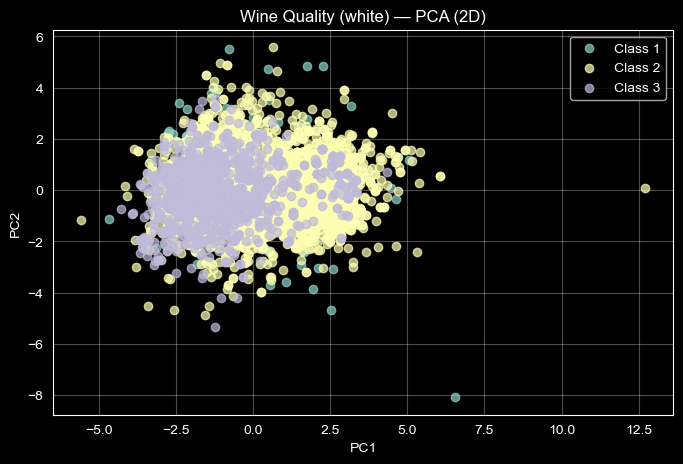

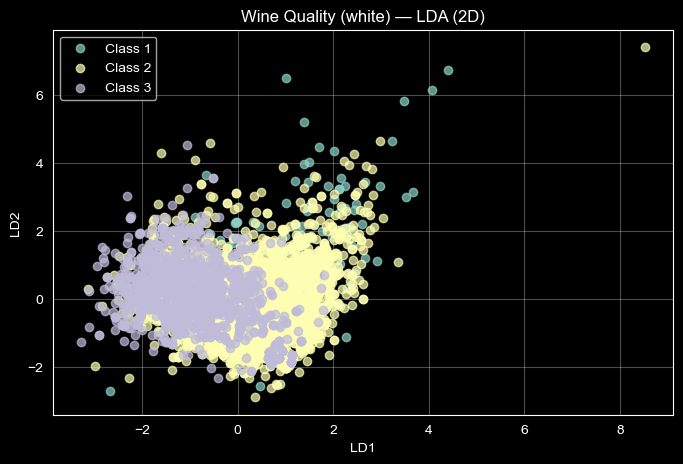

In [82]:
classes = np.unique(y)

plt.figure(figsize=(8, 5))
for cls in classes:
    mask = (y == cls)
    plt.scatter(X_pca2[mask, 0], X_pca2[mask, 1], alpha=0.7, label=f"Class {cls}")
plt.title("Wine Quality (white) — PCA (2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(8, 5))
for cls in classes:
    mask = (y == cls)
    plt.scatter(X_lda2[mask, 0], X_lda2[mask, 1], alpha=0.7, label=f"Class {cls}")
plt.title("Wine Quality (white) — LDA (2D)")
plt.xlabel("LD1")
plt.ylabel("LD2")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 9) Interpretation of results (what to look for)

### A) Class imbalance
If `quality3` is imbalanced (it usually is), **accuracy can be misleading**.
Macro F1 helps because it weights each class equally.

### B) PCA vs LDA plots
- PCA emphasizes where the dataset varies most (variance) → classes may overlap.
- LDA emphasizes directions that separate classes (supervised) → often cleaner class structure.

### C) Pipeline comparison
- If `LDA(2)+LogReg` improves **macro F1**, LDA is helping minority-class separation.
- If accuracy is similar but macro F1 improves → LDA is still valuable.
- If both drop → LDA may be removing useful information for this task.

### D) Next step (optional extension)
Try different binning schemes or a binary target ("good" vs "not good") and compare again.
